In [ ]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:
!pip install ultralytics==8.0.196

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 28.7 MB/s eta 0:00:00


In [ ]:
"""
Use your roboflow API key here
"""

API_KEY = 'XXXXXXXXXXXXXXXXXXXXXXXXX'

In [ ]:

from roboflow import Roboflow
rf = Roboflow(api_key= API_KEY)
project = rf.workspace("workspace-2-iz9jz").project("walls-2tpff")
version = project.version(1)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to walls-1 in yolov8:: 100%|██████████| 2226/2226 [00:00<00:00, 2834.79it/s]


In [ ]:
import os
import cv2
import numpy as np
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Google Drive best weight path
# Define paths
BEST_WEIGHTS_PATH = '/content/drive/My Drive/best_weights.h5'
base_dir = 'walls-1'
label_dirs = ['train/labels', 'valid/labels', 'test/labels']
image_dirs = ['train/images', 'valid/images', 'test/images']
mask_dirs = ['train/masks', 'valid/masks', 'test/masks']

# Create mask directories if they don't exist
for mask_dir in mask_dirs:
    os.makedirs(os.path.join(base_dir, mask_dir), exist_ok=True)

# Function to create masks
def create_masks(label_dir, image_dir, mask_dir):
    label_path = os.path.join(base_dir, label_dir)
    image_path = os.path.join(base_dir, image_dir)
    mask_path = os.path.join(base_dir, mask_dir)

    for label_file in os.listdir(label_path):
        if label_file.endswith('.txt'):
            # Read the corresponding image
            image_file = label_file.replace('.txt', '.jpg')
            image = cv2.imread(os.path.join(image_path, image_file))
            if image is None:
                continue

            height, width, _ = image.shape
            mask = np.zeros((height, width), dtype=np.uint8)

            # Read the label file
            with open(os.path.join(label_path, label_file), 'r') as file:
                for line in file:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center = float(parts[1]) * width
                    y_center = float(parts[2]) * height
                    bbox_width = float(parts[3]) * width
                    bbox_height = float(parts[4]) * height

                    x_min = int(x_center - bbox_width / 2)
                    y_min = int(y_center - bbox_height / 2)
                    x_max = int(x_center + bbox_width / 2)
                    y_max = int(y_center + bbox_height / 2)

                    # Draw the bounding box on the mask
                    cv2.rectangle(mask, (x_min, y_min), (x_max, y_max), (255), thickness=-1)

            # Save the mask
            mask_file = label_file.replace('.txt', '.png')
            cv2.imwrite(os.path.join(mask_path, mask_file), mask)

# Create masks for each dataset split
for label_dir, image_dir, mask_dir in zip(label_dirs, image_dirs, mask_dirs):
    create_masks(label_dir, image_dir, mask_dir)

In [ ]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
def load_images_and_masks(image_dir, mask_dir, image_size=(128, 128)):
    images = []
    masks = []

    for image_file in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, image_file.replace('.jpg', '.png'))

        if os.path.exists(mask_path):
            image = cv2.imread(image_path)
            image = cv2.resize(image, image_size)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, image_size)

            images.append(image)
            masks.append(mask)

    images = np.array(images) / 255.0
    masks = np.array(masks) / 255.0
    masks = np.expand_dims(masks, axis=-1)
    return images, masks

train_images, train_masks = load_images_and_masks(os.path.join(base_dir, 'train/images'), os.path.join(base_dir, 'train/masks'))
valid_images, valid_masks = load_images_and_masks(os.path.join(base_dir, 'valid/images'), os.path.join(base_dir, 'valid/masks'))
test_images, test_masks = load_images_and_masks(os.path.join(base_dir, 'test/images'), os.path.join(base_dir, 'test/masks'))


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

In [ ]:
# Define U-Net model with pretrained VGG16 encoder
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)

    # Encoder
    conv1 = vgg16.get_layer('block1_conv2').output
    pool1 = vgg16.get_layer('block1_pool').output
    conv2 = vgg16.get_layer('block2_conv2').output
    pool2 = vgg16.get_layer('block2_pool').output
    conv3 = vgg16.get_layer('block3_conv3').output
    pool3 = vgg16.get_layer('block3_pool').output
    conv4 = vgg16.get_layer('block4_conv3').output
    pool4 = vgg16.get_layer('block4_pool').output
    conv5 = vgg16.get_layer('block5_conv3').output

    # Decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create the model
model = unet_model()

#evo
# Eğer daha önce kaydedilmiş en iyi ağırlıklar varsa yükle
if os.path.exists(BEST_WEIGHTS_PATH):
    print("Loading best weights before training...")
    model.load_weights(BEST_WEIGHTS_PATH)
else:
    print("No best weights found, starting with default weights.")


# Print model summary
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 128, 128, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 64, 64, 64)     │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 64, 64, 128)    │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 64, 64, 128)    │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 32, 32, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 32, 32, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 16, 16, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 8, 8, 512)      │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 24,891,137 (94.95 MB)

 Trainable params: 24,891,137 (94.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
valid_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(train_images, train_masks, batch_size=16)
valid_generator = valid_datagen.flow(valid_images, valid_masks, batch_size=16)

#history = model.fit(train_generator, validation_data=valid_generator, epochs=50) #delete this pls

# En iyi ağırlıkları kaydetmek için ModelCheckpoint kullanımı #evo
checkpoint = ModelCheckpoint(BEST_WEIGHTS_PATH, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Modeli eğitimle beraber en iyi ağırlıkları kaydedecek şekilde eğitme
history = model.fit(train_generator, validation_data=valid_generator, epochs=50, callbacks=[checkpoint])



Epoch 1/50


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


61/61 ━━━━━━━━━━━━━━━━━━━━ 87s 853ms/step - accuracy: 0.5286 - loss: 2.2762 - val_accuracy: 0.4153 - val_loss: 0.7833
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - accuracy: 0.6069 - loss: 0.6592 - val_accuracy: 0.6319 - val_loss: 0.6440
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 216ms/step - accuracy: 0.6337 - loss: 0.6468 - val_accuracy: 0.6362 - val_loss: 0.6839
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 216ms/step - accuracy: 0.6555 - loss: 0.6306 - val_accuracy: 0.6337 - val_loss: 0.6729
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 217ms/step - accuracy: 0.6551 - loss: 0.6333 - val_accuracy: 0.5756 - val_loss: 0.6924
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 222ms/step - accuracy: 0.6523 - loss: 0.6351 - val_accuracy: 0.5852 - val_loss: 0.7512
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - accuracy: 0.6557 - loss: 0.6330 - val_accuracy: 0.6565 - val_loss: 0.6215
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - accuracy: 0.6527 - loss: 0.6297 - val_accuracy: 0.644

2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 11s/step - accuracy: 0.7747 - loss: 0.4620
Test Loss: 0.4680505096912384
Test Accuracy: 0.77131187915802


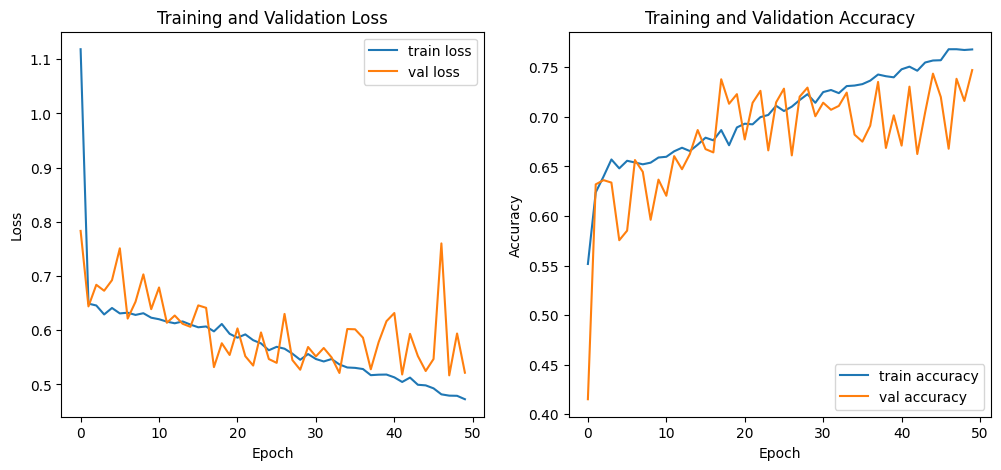

In [ ]:
loss, accuracy = model.evaluate(test_images, test_masks)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation loss
ax1.plot(history.history['loss'], label='train loss')
ax1.plot(history.history['val_loss'], label='val loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(history.history['accuracy'], label='train accuracy')
ax2.plot(history.history['val_accuracy'], label='val accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

# Show the plots
plt.show()


In [ ]:
#model = unet_model()   #evo
trainable_params = model.count_params()  # weight counter
print(f'Trainable ağırlık sayısı: {trainable_params}')  # print

# Eğitim tamamlandıktan sonra modeli değerlendir #evo
loss, accuracy = model.evaluate(test_images, test_masks)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


Trainable ağırlık sayısı: 24891137


In [ ]:
#save the model to drive

from tensorflow.keras.models import Sequential

# Örneğin, model oluşturulduktan sonra:
model.save('unet_model.h5')  # Modeli Colab ortamına kaydet

from google.colab import drive
drive.mount('/content/drive')
model.save('/content/drive/My Drive/unet_model.h5')


ValueError: mount failed

In [ ]:
import random

# Function to display images, masks, and predictions with white masks
def display_predictions(model, images, masks, num_examples=15):
    indices = random.sample(range(len(images)), num_examples)

    plt.figure(figsize=(15, num_examples * 5))
    for i, idx in enumerate(indices):
        image = images[idx]
        mask = masks[idx]
        prediction = model.predict(np.expand_dims(image, axis=0))[0]

        # Threshold the prediction to create binary mask
        thresholded_prediction = (prediction > 0.5).astype(np.uint8) * 255

        plt.subplot(num_examples, 3, i * 3 + 1)
        plt.title('Original Image')
        plt.imshow(image)
        plt.axis('off')

        plt.subplot(num_examples, 3, i * 3 + 2)
        plt.title('Ground Truth Mask')
        plt.imshow(mask.squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(num_examples, 3, i * 3 + 3)
        plt.title('Predicted Mask')
        plt.imshow(thresholded_prediction.squeeze(), cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display prediction examples on test images
display_predictions(model, test_images, test_masks)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def display_new_predictions(model, new_images, original_images, num_examples=5):
    indices = random.sample(range(len(new_images)), num_examples)

    plt.figure(figsize=(15, num_examples * 5))
    for i, idx in enumerate(indices):
        image = new_images[idx]
        original_image = original_images[idx]
        prediction = model.predict(np.expand_dims(image, axis=0))[0]

        # Threshold the prediction to create binary mask
        thresholded_prediction = (prediction > 0.5).astype(np.uint8) * 255

        plt.subplot(num_examples, 3, i * 3 + 1)
        plt.title('Original Image')
        plt.imshow(original_image)
        plt.axis('off')

        plt.subplot(num_examples, 3, i * 3 + 2)
        plt.title('Processed Image')
        plt.imshow(image)
        plt.axis('off')

        plt.subplot(num_examples, 3, i * 3 + 3)
        plt.title('Predicted Mask')
        plt.imshow(thresholded_prediction.squeeze(), cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display prediction examples on new images
display_new_predictions(model, new_images, original_images)


In [ ]:
import numpy as np #evo
import random
from copy import deepcopy


In [ ]:
# Ağırlıkları mutasyona uğratma fonksiyonu  #evo
def mutate_weights(weights, mutation_rate=0.01):
    new_weights = deepcopy(weights)
    for i in range(len(new_weights)):
        if len(new_weights[i].shape) > 1:
            mutation_mask = np.random.rand(*new_weights[i].shape) < mutation_rate
            mutation_values = np.random.randn(*new_weights[i].shape)
            new_weights[i][mutation_mask] += mutation_values[mutation_mask]
        else:
            new_weights[i] += np.random.randn(*new_weights[i].shape) * mutation_rate
    return new_weights


In [ ]:
# Ağırlıkları optimize etmek için fonksiyon #evo
def optimize_weights(model, train_data, train_masks, generations=20, population_size=10, mutation_rate=0.05):
    # En iyi ağırlıkları yükle
    if os.path.exists(BEST_WEIGHTS_PATH):
        print("Loading best weights...")
        model.load_weights(BEST_WEIGHTS_PATH)
    else:
        print("No best weights found, using initial model weights.")

    # Başlangıç popülasyonunu oluştur
    population = [deepcopy(model) for _ in range(population_size)]

    # Her modelin başlangıç fitness puanlarını hesapla
    population_fitness = [fitness_function(m, train_data, train_masks) for m in population]

    for generation in range(generations):
        print(f'Generation {generation+1}/{generations}')
        population_fitness = [fitness if np.isfinite(fitness) else 1e10 for fitness in population_fitness]
        selection_weights = [1 / fitness for fitness in population_fitness]

        if not all(np.isfinite(selection_weights)) or sum(selection_weights) == 0:
            selection_weights = [1e-6] * len(selection_weights)

        next_population = []
        for i in range(population_size):
            parent1, parent2 = random.choices(population, weights=selection_weights, k=2)
            child = deepcopy(parent1)
            child_weights = child.get_weights()
            child_weights = mutate_weights(child_weights, mutation_rate)
            child.set_weights(child_weights)
            next_population.append(child)

        population = next_population
        population_fitness = [fitness_function(m, train_data, train_masks) for m in population]
        best_fitness = min(population_fitness)
        print(f'Best Fitness: {best_fitness}')

    best_model = population[np.argmin(population_fitness)]
    best_model.save('/content/drive/My Drive/optimized_unet_model.h5')  # Optimize edilmiş modeli kaydet
    return best_model


In [ ]:
#evo
# Fitness fonksiyonu (loss'a dayalı)
def fitness_function(model, train_data, train_masks):
    score = model.evaluate(train_data, train_masks, verbose=0)
    return score[0]  # Loss'u kullanabiliriz (düşük olması daha iyi)


In [ ]:
# Modeli optimize et  #evo
optimized_model = optimize_weights(model, train_images, train_masks, generations=3, population_size=2, mutation_rate=0.01) # have to generations=20, population_size=10-20, mutation_rate=0.01-0.05

# Test verileri üzerinde optimize edilmiş modeli değerlendir
final_loss, final_accuracy = optimized_model.evaluate(test_images, test_masks)
print(f'Optimized Test Loss: {final_loss}')
print(f'Optimized Test Accuracy: {final_accuracy}')
